Random Forest - MAE : 1.2611248542497884, RMSE : 2.4670447330877687, R² : 0.8786276253731409
Régression Linéaire - MAE : 3.895863259654421, RMSE : 6.504202078975939, R² : 0.15636643163926012
SVM - MAE : 3.392286715521344, RMSE : 7.49464828047112, R² : -0.12012970166420534


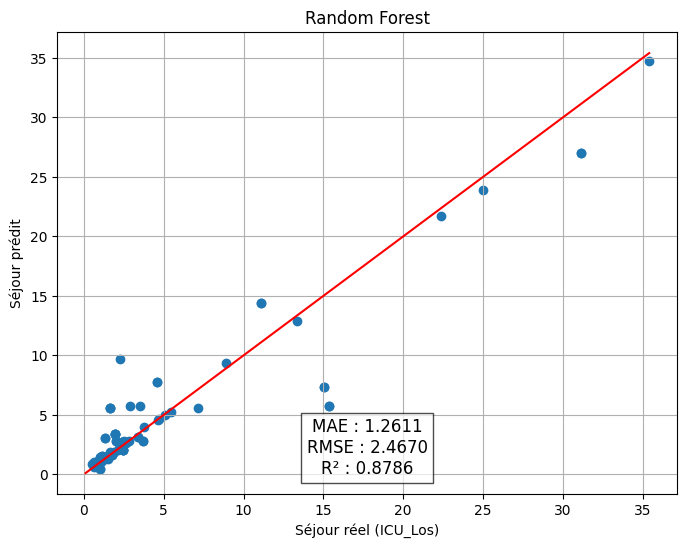

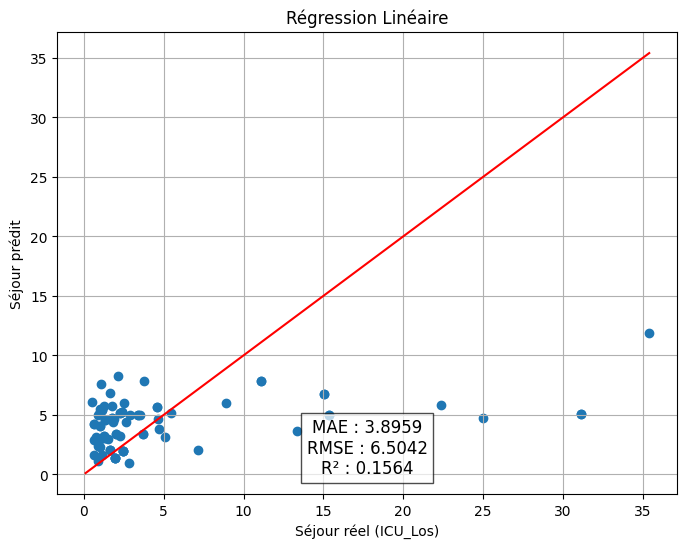

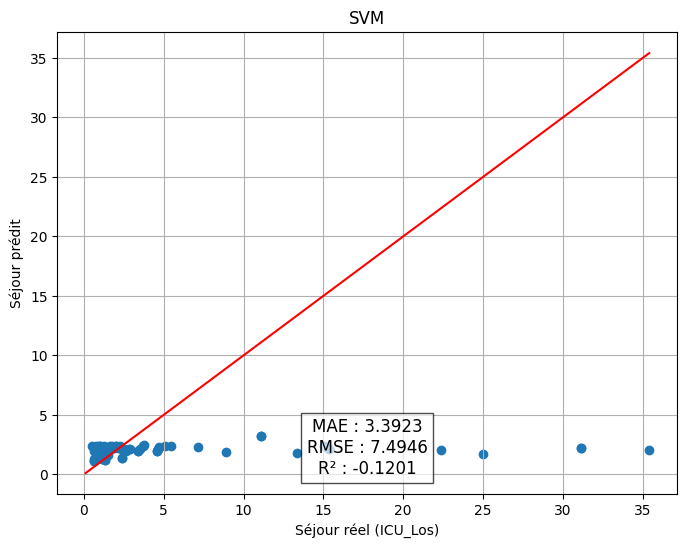


Interprétation dynamique :
Le modèle Random Forest est le meilleur modèle avec  le R² le plus élevé  le MAE le plus bas.


['regression_model.pkl']

In [3]:
# Importation des bibliothèques nécessaires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sqlalchemy import create_engine  
import joblib
# Connexion à PostgreSQL
USERNAME = os.getenv("POSTGRES_USER", "postgres")
PASSWORD = os.getenv("POSTGRES_PASSWORD", "123456789")
HOST = os.getenv("POSTGRES_HOST", "localhost")
PORT = os.getenv("POSTGRES_PORT", "5432")
DATABASE = os.getenv("POSTGRES_DB", "DBM")

DATABASE_URL = f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
engine = create_engine(DATABASE_URL, connect_args={'client_encoding': 'LATIN1'}) 

# Charger les données depuis la base de données PostgreSQL
query_stay = 'SELECT * FROM "DIM_PATIENT_STAY" '
query_pat = 'SELECT * FROM "Dim_Patient" '

df_stay = pd.read_sql(query_stay, engine)
df_pat = pd.read_sql(query_pat, engine)

# Calculer l'âge
df_pat["date_of_birth"] = pd.to_datetime(df_pat["date_of_birth"], errors='coerce')
 

# Fusionner les DataFrames
df = df_stay.merge(df_pat, on="hadm_id", how="left")

# Garder les colonnes pertinentes
df = df[["ICU_Los", "Gender", "Weight", "Height", "Bmi"]]
df = df.dropna() 

# Corriger les virgules et convertir en float
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(",", ".", regex=False)
        try:
            df[col] = df[col].astype(float)
        except:
            pass

# Encodage binaire du genre
df = pd.get_dummies(df, columns=["Gender"], drop_first=True)

# Séparation des données
X = df.drop("ICU_Los", axis=1)
y = df["ICU_Los"]

# Séparer en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Modèle RandomForest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Modèle Régression Linéaire
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

# Modèle SVM
svm_model = SVR()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Calcul des métriques pour chaque modèle
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Obtenir les métriques pour chaque modèle
rf_mae, rf_rmse, rf_r2 = get_metrics(y_test, rf_pred)
lr_mae, lr_rmse, lr_r2 = get_metrics(y_test, lr_pred)
svm_mae, svm_rmse, svm_r2 = get_metrics(y_test, svm_pred)

# Afficher les résultats des métriques
print(f"Random Forest - MAE : {rf_mae}, RMSE : {rf_rmse}, R² : {rf_r2}")
print(f"Régression Linéaire - MAE : {lr_mae}, RMSE : {lr_rmse}, R² : {lr_r2}")
print(f"SVM - MAE : {svm_mae}, RMSE : {svm_rmse}, R² : {svm_r2}")

# Visualisation des résultats - Random Forest
plt.figure(figsize=(8,6))
plt.scatter(y_test, rf_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r')
plt.xlabel("Séjour réel (ICU_Los)")
plt.ylabel("Séjour prédit")
plt.title("Random Forest")
plt.grid()
# Ajouter la précision sous le graphique
plt.text(0.5, 0.1, f"MAE : {rf_mae:.4f}\nRMSE : {rf_rmse:.4f}\nR² : {rf_r2:.4f}",
         transform=plt.gca().transAxes, ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.show()

# Visualisation des résultats - Régression Linéaire
plt.figure(figsize=(8,6))
plt.scatter(y_test, lr_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r')
plt.xlabel("Séjour réel (ICU_Los)")
plt.ylabel("Séjour prédit")
plt.title("Régression Linéaire")
plt.grid()
# Ajouter la précision sous le graphique
plt.text(0.5, 0.1, f"MAE : {lr_mae:.4f}\nRMSE : {lr_rmse:.4f}\nR² : {lr_r2:.4f}",
         transform=plt.gca().transAxes, ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.show()

# Visualisation des résultats - SVM
plt.figure(figsize=(8,6))
plt.scatter(y_test, svm_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r')
plt.xlabel("Séjour réel (ICU_Los)")
plt.ylabel("Séjour prédit")
plt.title("SVM")
plt.grid()
# Ajouter la précision sous le graphique
plt.text(0.5, 0.1, f"MAE : {svm_mae:.4f}\nRMSE : {svm_rmse:.4f}\nR² : {svm_r2:.4f}",
         transform=plt.gca().transAxes, ha='center', va='center', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.show()

# Comparaison des modèles pour l'interprétation
models = {
    "Random Forest": {"mae": rf_mae, "r2": rf_r2},
    "Régression Linéaire": {"mae": lr_mae, "r2": lr_r2},
    "SVM": {"mae": svm_mae, "r2": svm_r2}
}

# Trouver le modèle avec le MAE le plus bas et le R² le plus élevé
best_mae_model = min(models, key=lambda x: models[x]["mae"])
best_r2_model = max(models, key=lambda x: models[x]["r2"])

# Interprétation dynamique
if best_mae_model == best_r2_model:
    interpretation = f"Le modèle {best_mae_model} est le meilleur modèle avec  le R² le plus élevé  le MAE le plus bas."
else:
    interpretation = (f"Le modèle avec le MAE le plus bas est {best_mae_model}, tandis que le modèle avec le R² le plus élevé est "
                      f"{best_r2_model}. Cela suggère que {best_mae_model} minimise les erreurs moyennes, tandis que "
                      f"{best_r2_model} explique le mieux la variance des données.")

# Affichage de l'interprétation
print("\nInterprétation dynamique :")
print(interpretation)



# Supposons que tu veux sauvegarder le modèle Random Forest
joblib.dump(rf_model, "regression_model.pkl")

